# Pneumonia Classifier using ViT

This notebook is the continuation of the [Pneumonia Chest X-Ray Dataset to Hugging Face Hub](https://www.kaggle.com/mmenendezg/pneumonia-chest-x-ray-dataset-to-hugging-face-hub/edit) notebook. 

In this serie, the goal is to take the `Pneumonia Chest X-Ray` dataset, upload it to the [`Hugging Face Hub`](https://huggingface.co/datasets/mmenendezg/pneumonia_x_ray), create a classifier to detect pneumonia, and finally upload the model to the Hugging Face Hub. 

Let's train the model and evaluate the results we can get when using a ViT to classify medical images.

## Introduction

When working with image classification related to medical diagnosis, it is important to provide as much information as possible related to the result and the reasons that support it. It is important in medicine to be able to understand and track the reasons behind a decision.

It is crucial then a good classifier capable of providing good predictions, but as well a model that provides some level of insight into the reason behind the result. 

That is why ViT (Visual Transformers) makes a good classifier option. ViT outperforms previous CNN architectures in the level of accuracy of the predictions, but also provides a new feature: Attention. 

The attention vectors allow to visualize where the model is paying more attention in the image when predicting a class or another. 

ViT is the evolution of the regular Transformers but applied to the computer vision field. The way this is implemented is quite clever: whereas the original Transformer was designed with text sequences in mind, the ViT was adapted to images. Images are not sequences neither are composed of them, but an image can be conceived as composed by several patches (parts of the original image).

As it can be seen in the image below, the original image is cut into patches, these patches are flattened (the shape is similar to a text sequence), and then it is passed to the embedding and the positional information is added. 

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png" style="display: block;margin-left: auto; margin-right: auto; width: 50%;">
>> Imgae of

With this short introduction, let's train a classifier to identify if a chest x-ray image belongs to a patient with pneumonia or not, and also represent where the model is paying attention to when making these predictions.


## Setup

Let's first import the libraries we will use in this notebook:

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from PIL import Image

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, metrics, Sequential, losses, models
from tensorflow.keras.optimizers.legacy import Nadam

# Hugging Face
import datasets
from transformers import TFViTModel


- TFVitForImageClassification contains an output head and a loss function, not suitable for transfer learning

The authors recommend to use higher resolution: 

https://huggingface.co/google/vit-base-patch16-224

Now, let's define the constants we will use in this notebook:

In [2]:
DATASET_NAME = "mmenendezg/pneumonia_x_ray"
MODEL_NAME = "google/vit-base-patch16-224"
MODEL_FILEPATH = "../models/pneumonia_classifier/"
MODEL_PATCH_SIZE = 16

IMG_SIZE = [384, 384]
IMG_CLASSES = ["Normal", "Pneumonia"]
BATCH_SIZE = 16
THRESHOLD = 0.65

SEED = 92
AUTOTUNE = tf.data.AUTOTUNE


We will use the ViT Base pretrained model by Google. This model creates patches of `16x16`, and it was trained on images of size `224x224`.

Note that the `IMG_SIZE` constant containing the size of the image to be fed to the model for training, and this size is bigger than those used to pretrain the ViT. This is due to the suggestion made by the authors of the model where they suggest to use images with bigger resolution for fine-tunning, being `384x384` the resolution they suggest to use.

## Load and preprocess the dataset

We will load the dataset uploaded to Hugging Face, and then we will preprocess it. Let's first define the helper functions to do it:

In [3]:
image_preprocessor = Sequential(
    [
        layers.Resizing(
            height=IMG_SIZE[0],
            width=IMG_SIZE[1],
            interpolation="nearest",
        ),
        layers.Rescaling(scale=1.0 / 255.0),
    ]
)


def format_dataset(example: dict):
    """
    Formats the dataset for training and evaluation.

    Args:
        example: A dictionary containing the image and label data.

    Returns:
        The image and label data, as a tuple.
    """
    return image_preprocessor(example["image"]), example["label"]


def transpose_images(image: tf.Tensor, label: tf.Tensor):
    """
    Transposes the images to the format expected by the model.

    Args:
        image: A tensor containing the image data.
        label: A tensor containing the label data.

    Returns:
        The transposed image data and label data, as a tuple.
    """
    # The vit model expects an image with shape [channel, height, width]
    image = tf.transpose(image, perm=[2, 0, 1])
    return image, label


def convert_tf_dataset(dataset: datasets.Dataset, shuffle: bool = False):
    """
    Convert a dataset to a tf.Dataset object.

    Args:
        dataset: The dataset to convert.
        shuffle: Whether to shuffle the dataset.

    Returns:
        The converted tf.Dataset object.
    """
    tf_dataset = (
        dataset.to_tf_dataset(batch_size=1)
        .unbatch()
        .map(format_dataset, num_parallel_calls=AUTOTUNE)
        .map(transpose_images, num_parallel_calls=AUTOTUNE)
    )
    if shuffle:
        tf_dataset.shuffle(dataset.num_rows)

    tf_dataset = tf_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return tf_dataset


def load_dataset():
    """
    Load the pneumonia dataset and split it into training, validation, and test sets.

    Returns:
        The training, validation, and test datasets.
    """
    pneumonia_dataset = datasets.load_dataset(DATASET_NAME)
    train_ds = convert_tf_dataset(pneumonia_dataset["train"], shuffle=True)
    valid_ds = convert_tf_dataset(pneumonia_dataset["validation"])
    test_ds = convert_tf_dataset(pneumonia_dataset["test"])

    return train_ds, valid_ds, test_ds


First we will give the tuple format to the images and labels in the dataset. Hugging Face datasets use dictionary format. Then, we will transpose the images to go from shape `[heigh, width, channel]` to `[channel, height, width]`, this due to the ViT model that expects vectors with this shape. Finally we batch the dataset and prefetch it. 

And now, let's load the splits of the dataset we will use.

In [4]:
train_ds, valid_ds, test_ds = load_dataset()


Found cached dataset parquet (/Users/mmenendezg/.cache/huggingface/datasets/mmenendezg___parquet/mmenendezg--pneumonia_x_ray-dc9536d94ef23b61/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

## Train the model

In [5]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)


The classifier will be a model that has an `Input` layer expecting vectors of shape `[3, 384, 384]` (channel first), an image augmentator block, the ViT model, and the Dense Layer. 

The `TFViTModel` is used instead of the `TFViTForImageClassification` because the latter includes a classification head on top, and the first does not. This allows to train a custom classification head. The classification head for this model will be a `Dense` layer with just one output, and `sigmoid` as the activation function. This will saturate the output between 0 (Normal) and 1 (Pneumonia).

Additionally, the `VitModel` class is a general-purpose ViT model that can be used for a variety of tasks, such as image classification, object detection, and segmentation. The target here is the classifier to be able to capture more spatial information of the image, and this to be reflected when visualizing the attention vectors.

In [6]:
class PneumoniaClassifier(keras.Model):
    """
    A class that classifies images of pneumonia.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.inputs_layer = layers.Input(
            shape=(3, IMG_SIZE[0], IMG_SIZE[1]), dtype=tf.float32
        )
        self.image_augmentation = Sequential(
            [
                layers.RandomFlip(mode="horizontal"),
                layers.RandomRotation(factor=0.2),
                layers.RandomZoom(height_factor=0.2, width_factor=0.2),
            ]
        )
        self.vit_model = TFViTModel.from_pretrained(MODEL_NAME)
        self.output_layer = layers.Dense(1, activation="sigmoid")
        self.flatten = layers.Flatten()

    def call(self, inputs):
        """
        Performs image augmentation, ViT classification, and output layer classification.

        Args:
            inputs: The input image data.

        Returns:
            The classification results.
        """
        x = self.image_augmentation(inputs)

        # interpolate_pos_encoding argument allows the model to be trained on bigger images
        x = self.vit_model.vit(x, output_attentions=True, interpolate_pos_encoding=True)

        # Get the attention of the last layer (-1)
        attention_outputs = x.attentions[-1]
        # Flatten the attention vectors to have shape (None,). We will reshape them later
        attention_outputs = self.flatten(attention_outputs)

        # Get the outputs of the vit
        vit_outputs = x[0]
        outputs = self.output_layer(vit_outputs[:, 0, :])

        # Both have shape (None,)
        return outputs, attention_outputs


Let's also create some helper functions for the training of the model:

In [7]:
# Create a Learning Rate Scheduler
def exponential_decay_with_warmup(
    lr_start: float = 1e-4,
    lr_rampup_epochs: int = 4,
    lr_sustain_epochs: int = 1,
    lr_exp_decay: float = 0.8,
):
    """Implements exponential decay learning rate with warm up.

    example:
        lr_function = exponential_decay_wtih_warmup()
        lr_cb = tf.keras.callbacks.LearningRateScheduler(lr_function)

    Args:
        lr_start (float, optional): Initial value of the learning rate. Defaults to 0.0001.
        lr_rampup_epochs (int, optional): Number of epochs that the learning rate will increase up to lr_max. Defaults to 4.
        lr_sustain_epochs (int, optional): Number of epochs the learning rate will be equal to lr_max. Defaults to 1.
        lr_exp_decay (float, optional): Factor in which the learning rate will decay. Defaults to 0.8.
    """
    lr_max = lr_start * 10
    lr_min = lr_start / 10

    def exponential_decay_fn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < (lr_rampup_epochs + lr_sustain_epochs):
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (
                epoch - lr_rampup_epochs - lr_sustain_epochs
            ) + lr_min

        return lr

    return exponential_decay_fn


def get_logdir(date_type: str = "date", path_folder: str = None):
    """This function creates the name of a folder for Tensorboard
    logs using the current date or datetime

    Args:
        date_type (str, optional): Format of the second part of the folder name. Defaults to "date".
        path_folder (str, optional): String of the path to add before the folder name. Defaults to None.

    Returns:
        str: Name of the folder or path of the folder.
    """
    if date_type == "datetime":
        log_dir = datetime.now().strftime("%Y%m%d_%H%M%S")
        log_dir = f"run_{log_dir}"
    elif date_type == "date":
        log_dir = datetime.now().strftime("%Y%m%d")
        log_dir = f"run_{log_dir}"

    if path_folder:
        log_dir = os.path.join(path_folder, log_dir)

    return log_dir


As explained in the [notebook](https://www.kaggle.com/mmenendezg/pneumonia-chest-x-ray-dataset-to-hugging-face-hub/edit) where we uploaded the dataset to the Hugging Face Hub, this dataset is unbalanced. There are more images of the class `Pneumonia` class than images of the `Normal` class. Using accuracy in this case is not the best option to measure the performance of the model. Instead, a better option is to use the recall metric, i.e., the percentage of true positives that were correctly classified. Here the formula:

$$\text{Recall} = \frac{\text{True positives}}{\text{True positives} + \text{false negatives}}$$

In this case, the goal is to correctly identify the patients that suffer from pneumonia for their treatment. That is why the classifier will focus on this metric. Binary accuracy and precision will be monitored as well to understand what is the overall performance of the model. 

After running some tests, the optimal learning rate turned out to be at `1e-6`. A learning rate scheduler (`exponential_decay_with_warmup`) will be used to schedule the behaviour of the learning rate value. 

The image below illustrates what the `exponential_decay_with_warmup` function does: it starts at `lr_start` and by `lr_rampup_epochs` epochs it increases up to the `lr_max` value. It remains at that value by `lr_sustain_epochs` epochs, and then it starts decreasing exponentially with a factor equivalent to `lr_exp_decay`.

![Learning rate behaviour](https://storage.googleapis.com/mmenendezg-ml-bucket/models/pneumonia_folder/img/learning_rate.png)

In [8]:
def train_model(
    model: tf.keras.Model,
    train_dataset: tf.data.Dataset,
    valid_dataset: tf.data.Dataset,
    learning_rate: float = 1e-4,
    epochs: int = 5,
):
    """
    Trains a Keras model on the given dataset.

    Args:
        model: The Keras model to train.
        train_dataset: The training dataset.
        valid_dataset: The validation dataset.
        learning_rate: The learning rate to use.
        epochs: The number of epochs to train for.

    Returns:
        The trained model.
    """
    # Compile the model
    optimizer = Nadam()
    losses_list = {"output_1": losses.binary_crossentropy, "output_2": None}
    metrics_ = [
        [
            metrics.BinaryAccuracy(threshold=THRESHOLD),
            metrics.Recall(thresholds=THRESHOLD),
            metrics.Precision(thresholds=THRESHOLD),
        ],
        None,
    ]

    model.compile(optimizer=optimizer, loss=losses_list, metrics=metrics_)

    # Callbacks
    # Learning rate scheduler
    lr_scheduler = exponential_decay_with_warmup(
        lr_start=learning_rate, lr_rampup_epochs=2
    )
    learning_rate_cb = callbacks.LearningRateScheduler(lr_scheduler)

    # Tensorboard callback to monitor the training of the model
    logdir = get_logdir("datetime", "../reports/logs")
    tensorboard_cb = callbacks.TensorBoard(
        histogram_freq=1, log_dir=logdir, profile_batch=(10, 40)
    )
    
    # Model Checkpoint to save the best version of the model
    model_checkpoint_dir = get_logdir("datetime", "../models/")
    model_checkpoint_cb = callbacks.ModelCheckpoint(
        save_best_only=True, filepath=model_checkpoint_dir
    )

    callbacks_ = [learning_rate_cb, tensorboard_cb, model_checkpoint_cb]

    # Train the model
    model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks_,
    )

    model.load_weights(model_checkpoint_dir)

    return model


Including the callbacks to the training function assures that it is possible to monitor the training stats while performing. 

At the end of the function, the weights of the model are updated to the best model in training, and it is this updated model that is returned. 

Let's now train the model for 30 epochs:

In [9]:
trained_model = train_model(
    PneumoniaClassifier(),
    train_dataset=train_ds,
    valid_dataset=valid_ds,
    learning_rate=1e-6,
    epochs=30,
)


Some layers from the model checkpoint at google/vit-base-patch16-224 were not used when initializing TFViTModel: ['classifier']

- This IS expected if you are initializing TFViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing TFViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Some layers of TFViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30



    262/Unknown - 874s 3s/step - loss: 0.2267 - output_1_loss: 0.2267 - output_1_binary_accuracy: 0.9064 - output_1_recall: 0.8754 - output_1_precision: 0.9982INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 973s 4s/step - loss: 0.2267 - output_1_loss: 0.2267 - output_1_binary_accuracy: 0.9064 - output_1_recall: 0.8754 - output_1_precision: 0.9982 - val_loss: 0.8344 - val_output_1_loss: 0.8344 - val_output_1_binary_accuracy: 0.7426 - val_output_1_recall: 1.0000 - val_output_1_precision: 0.7426 - lr: 1.0000e-06

Epoch 2/30

262/262 [==============================] - 885s 3s/step - loss: 0.0686 - output_1_loss: 0.0686 - output_1_binary_accuracy: 0.9754 - output_1_recall: 0.9788 - output_1_precision: 0.9880 - val_loss: 1.0896 - val_output_1_loss: 1.0896 - val_output_1_binary_accuracy: 0.7426 - val_output_1_recall: 1.0000 - val_output_1_precision: 0.7426 - lr: 5.5000e-06

Epoch 3/30

262/262 [==============================] - 879s 3s/step - loss: 0.0605 - output_1_loss: 0.0605 - output_1_binary_accuracy: 0.9833 - output_1_recall: 0.9874 - output_1_precision: 0.9900 - val_loss: 1.6630 - val_output_1_loss: 1.6630 - val_output_1_binary_accuracy: 0.7426 -

INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 903s 3s/step - loss: 0.0871 - output_1_loss: 0.0871 - output_1_binary_accuracy: 0.9685 - output_1_recall: 0.9752 - output_1_precision: 0.9822 - val_loss: 0.8155 - val_output_1_loss: 0.8155 - val_output_1_binary_accuracy: 0.7426 - val_output_1_recall: 1.0000 - val_output_1_precision: 0.7426 - lr: 6.4360e-06

Epoch 7/30

262/262 [==============================] - ETA: 0s - loss: 0.0896 - output_1_loss: 0.0896 - output_1_binary_accuracy: 0.9663 - output_1_recall: 0.9746 - output_1_precision: 0.9799INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 906s 3s/step - loss: 0.0896 - output_1_loss: 0.0896 - output_1_binary_accuracy: 0.9663 - output_1_recall: 0.9746 - output_1_precision: 0.9799 - val_loss: 0.6716 - val_output_1_loss: 0.6716 - val_output_1_binary_accuracy: 0.7426 - val_output_1_recall: 1.0000 - val_output_1_precision: 0.7426 - lr: 5.1688e-06

Epoch 8/30

262/262 [==============================] - ETA: 0s - loss: 0.1084 - output_1_loss: 0.1084 - output_1_binary_accuracy: 0.9611 - output_1_recall: 0.9710 - output_1_precision: 0.9764INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 905s 3s/step - loss: 0.1084 - output_1_loss: 0.1084 - output_1_binary_accuracy: 0.9611 - output_1_recall: 0.9710 - output_1_precision: 0.9764 - val_loss: 0.6241 - val_output_1_loss: 0.6241 - val_output_1_binary_accuracy: 0.7550 - val_output_1_recall: 1.0000 - val_output_1_precision: 0.7519 - lr: 4.1550e-06

Epoch 9/30

262/262 [==============================] - ETA: 0s - loss: 0.1093 - output_1_loss: 0.1093 - output_1_binary_accuracy: 0.9572 - output_1_recall: 0.9649 - output_1_precision: 0.9772INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 903s 3s/step - loss: 0.1093 - output_1_loss: 0.1093 - output_1_binary_accuracy: 0.9572 - output_1_recall: 0.9649 - output_1_precision: 0.9772 - val_loss: 0.5344 - val_output_1_loss: 0.5344 - val_output_1_binary_accuracy: 0.7560 - val_output_1_recall: 1.0000 - val_output_1_precision: 0.7527 - lr: 3.3440e-06

Epoch 10/30

262/262 [==============================] - ETA: 0s - loss: 0.1136 - output_1_loss: 0.1136 - output_1_binary_accuracy: 0.9520 - output_1_recall: 0.9633 - output_1_precision: 0.9718INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1010s 4s/step - loss: 0.1136 - output_1_loss: 0.1136 - output_1_binary_accuracy: 0.9520 - output_1_recall: 0.9633 - output_1_precision: 0.9718 - val_loss: 0.4167 - val_output_1_loss: 0.4167 - val_output_1_binary_accuracy: 0.8268 - val_output_1_recall: 0.9987 - val_output_1_precision: 0.8115 - lr: 2.6952e-06

Epoch 11/30

262/262 [==============================] - ETA: 0s - loss: 0.1082 - output_1_loss: 0.1082 - output_1_binary_accuracy: 0.9558 - output_1_recall: 0.9640 - output_1_precision: 0.9762INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1022s 4s/step - loss: 0.1082 - output_1_loss: 0.1082 - output_1_binary_accuracy: 0.9558 - output_1_recall: 0.9640 - output_1_precision: 0.9762 - val_loss: 0.3484 - val_output_1_loss: 0.3484 - val_output_1_binary_accuracy: 0.8746 - val_output_1_recall: 0.9961 - val_output_1_precision: 0.8579 - lr: 2.1762e-06

Epoch 12/30

262/262 [==============================] - ETA: 0s - loss: 0.1059 - output_1_loss: 0.1059 - output_1_binary_accuracy: 0.9575 - output_1_recall: 0.9630 - output_1_precision: 0.9794INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 898s 3s/step - loss: 0.1059 - output_1_loss: 0.1059 - output_1_binary_accuracy: 0.9575 - output_1_recall: 0.9630 - output_1_precision: 0.9794 - val_loss: 0.2694 - val_output_1_loss: 0.2694 - val_output_1_binary_accuracy: 0.9158 - val_output_1_recall: 0.9948 - val_output_1_precision: 0.9019 - lr: 1.7609e-06

Epoch 13/30

262/262 [==============================] - ETA: 0s - loss: 0.0977 - output_1_loss: 0.0977 - output_1_binary_accuracy: 0.9620 - output_1_recall: 0.9659 - output_1_precision: 0.9826INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 895s 3s/step - loss: 0.0977 - output_1_loss: 0.0977 - output_1_binary_accuracy: 0.9620 - output_1_recall: 0.9659 - output_1_precision: 0.9826 - val_loss: 0.1943 - val_output_1_loss: 0.1943 - val_output_1_binary_accuracy: 0.9474 - val_output_1_recall: 0.9897 - val_output_1_precision: 0.9423 - lr: 1.4288e-06

Epoch 14/30

262/262 [==============================] - 995s 4s/step - loss: 0.1000 - output_1_loss: 0.1000 - output_1_binary_accuracy: 0.9582 - output_1_recall: 0.9630 - output_1_precision: 0.9803 - val_loss: 0.1975 - val_output_1_loss: 0.1975 - val_output_1_binary_accuracy: 0.9416 - val_output_1_recall: 0.9897 - val_output_1_precision: 0.9354 - lr: 1.1630e-06

Epoch 15/30

262/262 [==============================] - ETA: 0s - loss: 0.1020 - output_1_loss: 0.1020 - output_1_binary_accuracy: 0.9599 - output_1_recall: 0.9636 - output_1_precision: 0.9820INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1043s 4s/step - loss: 0.1020 - output_1_loss: 0.1020 - output_1_binary_accuracy: 0.9599 - output_1_recall: 0.9636 - output_1_precision: 0.9820 - val_loss: 0.1852 - val_output_1_loss: 0.1852 - val_output_1_binary_accuracy: 0.9464 - val_output_1_recall: 0.9884 - val_output_1_precision: 0.9423 - lr: 9.5040e-07

Epoch 16/30

262/262 [==============================] - ETA: 0s - loss: 0.1030 - output_1_loss: 0.1030 - output_1_binary_accuracy: 0.9580 - output_1_recall: 0.9627 - output_1_precision: 0.9803INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1045s 4s/step - loss: 0.1030 - output_1_loss: 0.1030 - output_1_binary_accuracy: 0.9580 - output_1_recall: 0.9627 - output_1_precision: 0.9803 - val_loss: 0.1627 - val_output_1_loss: 0.1627 - val_output_1_binary_accuracy: 0.9550 - val_output_1_recall: 0.9884 - val_output_1_precision: 0.9528 - lr: 7.8032e-07

Epoch 17/30

262/262 [==============================] - ETA: 0s - loss: 0.1010 - output_1_loss: 0.1010 - output_1_binary_accuracy: 0.9592 - output_1_recall: 0.9627 - output_1_precision: 0.9819INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1046s 4s/step - loss: 0.1010 - output_1_loss: 0.1010 - output_1_binary_accuracy: 0.9592 - output_1_recall: 0.9627 - output_1_precision: 0.9819 - val_loss: 0.1391 - val_output_1_loss: 0.1391 - val_output_1_binary_accuracy: 0.9617 - val_output_1_recall: 0.9858 - val_output_1_precision: 0.9635 - lr: 6.4426e-07

Epoch 18/30

262/262 [==============================] - ETA: 0s - loss: 0.1029 - output_1_loss: 0.1029 - output_1_binary_accuracy: 0.9561 - output_1_recall: 0.9585 - output_1_precision: 0.9819INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1044s 4s/step - loss: 0.1029 - output_1_loss: 0.1029 - output_1_binary_accuracy: 0.9561 - output_1_recall: 0.9585 - output_1_precision: 0.9819 - val_loss: 0.1287 - val_output_1_loss: 0.1287 - val_output_1_binary_accuracy: 0.9636 - val_output_1_recall: 0.9858 - val_output_1_precision: 0.9659 - lr: 5.3541e-07

Epoch 19/30

262/262 [==============================] - ETA: 0s - loss: 0.0984 - output_1_loss: 0.0984 - output_1_binary_accuracy: 0.9592 - output_1_recall: 0.9591 - output_1_precision: 0.9854INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1043s 4s/step - loss: 0.0984 - output_1_loss: 0.0984 - output_1_binary_accuracy: 0.9592 - output_1_recall: 0.9591 - output_1_precision: 0.9854 - val_loss: 0.1208 - val_output_1_loss: 0.1208 - val_output_1_binary_accuracy: 0.9656 - val_output_1_recall: 0.9858 - val_output_1_precision: 0.9684 - lr: 4.4833e-07

Epoch 20/30

262/262 [==============================] - ETA: 0s - loss: 0.0969 - output_1_loss: 0.0969 - output_1_binary_accuracy: 0.9599 - output_1_recall: 0.9604 - output_1_precision: 0.9851INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1047s 4s/step - loss: 0.0969 - output_1_loss: 0.0969 - output_1_binary_accuracy: 0.9599 - output_1_recall: 0.9604 - output_1_precision: 0.9851 - val_loss: 0.1143 - val_output_1_loss: 0.1143 - val_output_1_binary_accuracy: 0.9656 - val_output_1_recall: 0.9858 - val_output_1_precision: 0.9684 - lr: 3.7866e-07

Epoch 21/30

262/262 [==============================] - ETA: 0s - loss: 0.0963 - output_1_loss: 0.0963 - output_1_binary_accuracy: 0.9618 - output_1_recall: 0.9623 - output_1_precision: 0.9858INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1057s 4s/step - loss: 0.0963 - output_1_loss: 0.0963 - output_1_binary_accuracy: 0.9618 - output_1_recall: 0.9623 - output_1_precision: 0.9858 - val_loss: 0.1015 - val_output_1_loss: 0.1015 - val_output_1_binary_accuracy: 0.9675 - val_output_1_recall: 0.9794 - val_output_1_precision: 0.9769 - lr: 3.2293e-07

Epoch 22/30

262/262 [==============================] - ETA: 0s - loss: 0.0934 - output_1_loss: 0.0934 - output_1_binary_accuracy: 0.9644 - output_1_recall: 0.9646 - output_1_precision: 0.9872INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1054s 4s/step - loss: 0.0934 - output_1_loss: 0.0934 - output_1_binary_accuracy: 0.9644 - output_1_recall: 0.9646 - output_1_precision: 0.9872 - val_loss: 0.1005 - val_output_1_loss: 0.1005 - val_output_1_binary_accuracy: 0.9694 - val_output_1_recall: 0.9820 - val_output_1_precision: 0.9769 - lr: 2.7834e-07

Epoch 23/30

262/262 [==============================] - ETA: 0s - loss: 0.0924 - output_1_loss: 0.0924 - output_1_binary_accuracy: 0.9625 - output_1_recall: 0.9643 - output_1_precision: 0.9849INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1055s 4s/step - loss: 0.0924 - output_1_loss: 0.0924 - output_1_binary_accuracy: 0.9625 - output_1_recall: 0.9643 - output_1_precision: 0.9849 - val_loss: 0.0959 - val_output_1_loss: 0.0959 - val_output_1_binary_accuracy: 0.9665 - val_output_1_recall: 0.9768 - val_output_1_precision: 0.9781 - lr: 2.4267e-07

Epoch 24/30

262/262 [==============================] - ETA: 0s - loss: 0.0884 - output_1_loss: 0.0884 - output_1_binary_accuracy: 0.9639 - output_1_recall: 0.9640 - output_1_precision: 0.9871INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1056s 4s/step - loss: 0.0884 - output_1_loss: 0.0884 - output_1_binary_accuracy: 0.9639 - output_1_recall: 0.9640 - output_1_precision: 0.9871 - val_loss: 0.0919 - val_output_1_loss: 0.0919 - val_output_1_binary_accuracy: 0.9656 - val_output_1_recall: 0.9729 - val_output_1_precision: 0.9805 - lr: 2.1414e-07

Epoch 25/30

262/262 [==============================] - ETA: 0s - loss: 0.0922 - output_1_loss: 0.0922 - output_1_binary_accuracy: 0.9637 - output_1_recall: 0.9633 - output_1_precision: 0.9875INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1055s 4s/step - loss: 0.0922 - output_1_loss: 0.0922 - output_1_binary_accuracy: 0.9637 - output_1_recall: 0.9633 - output_1_precision: 0.9875 - val_loss: 0.0907 - val_output_1_loss: 0.0907 - val_output_1_binary_accuracy: 0.9675 - val_output_1_recall: 0.9729 - val_output_1_precision: 0.9831 - lr: 1.9131e-07

Epoch 26/30

262/262 [==============================] - ETA: 0s - loss: 0.0915 - output_1_loss: 0.0915 - output_1_binary_accuracy: 0.9647 - output_1_recall: 0.9656 - output_1_precision: 0.9865INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1053s 4s/step - loss: 0.0915 - output_1_loss: 0.0915 - output_1_binary_accuracy: 0.9647 - output_1_recall: 0.9656 - output_1_precision: 0.9865 - val_loss: 0.0895 - val_output_1_loss: 0.0895 - val_output_1_binary_accuracy: 0.9675 - val_output_1_recall: 0.9716 - val_output_1_precision: 0.9843 - lr: 1.7305e-07

Epoch 27/30

262/262 [==============================] - ETA: 0s - loss: 0.0859 - output_1_loss: 0.0859 - output_1_binary_accuracy: 0.9635 - output_1_recall: 0.9640 - output_1_precision: 0.9865INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1055s 4s/step - loss: 0.0859 - output_1_loss: 0.0859 - output_1_binary_accuracy: 0.9635 - output_1_recall: 0.9640 - output_1_precision: 0.9865 - val_loss: 0.0878 - val_output_1_loss: 0.0878 - val_output_1_binary_accuracy: 0.9627 - val_output_1_recall: 0.9652 - val_output_1_precision: 0.9842 - lr: 1.5844e-07

Epoch 28/30

262/262 [==============================] - ETA: 0s - loss: 0.0876 - output_1_loss: 0.0876 - output_1_binary_accuracy: 0.9635 - output_1_recall: 0.9633 - output_1_precision: 0.9871INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1051s 4s/step - loss: 0.0876 - output_1_loss: 0.0876 - output_1_binary_accuracy: 0.9635 - output_1_recall: 0.9633 - output_1_precision: 0.9871 - val_loss: 0.0874 - val_output_1_loss: 0.0874 - val_output_1_binary_accuracy: 0.9656 - val_output_1_recall: 0.9691 - val_output_1_precision: 0.9843 - lr: 1.4675e-07

Epoch 29/30

262/262 [==============================] - ETA: 0s - loss: 0.0814 - output_1_loss: 0.0814 - output_1_binary_accuracy: 0.9673 - output_1_recall: 0.9668 - output_1_precision: 0.9888INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1053s 4s/step - loss: 0.0814 - output_1_loss: 0.0814 - output_1_binary_accuracy: 0.9673 - output_1_recall: 0.9668 - output_1_precision: 0.9888 - val_loss: 0.0861 - val_output_1_loss: 0.0861 - val_output_1_binary_accuracy: 0.9646 - val_output_1_recall: 0.9678 - val_output_1_precision: 0.9843 - lr: 1.3740e-07

Epoch 30/30

262/262 [==============================] - ETA: 0s - loss: 0.0852 - output_1_loss: 0.0852 - output_1_binary_accuracy: 0.9675 - output_1_recall: 0.9672 - output_1_precision: 0.9888INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


INFO:tensorflow:Assets written to: ../models/run_20230721_221258/assets


262/262 [==============================] - 1052s 4s/step - loss: 0.0852 - output_1_loss: 0.0852 - output_1_binary_accuracy: 0.9675 - output_1_recall: 0.9672 - output_1_precision: 0.9888 - val_loss: 0.0852 - val_output_1_loss: 0.0852 - val_output_1_binary_accuracy: 0.9636 - val_output_1_recall: 0.9652 - val_output_1_precision: 0.9855 - lr: 1.2992e-07


Once the training is finished, it is possible to evaluate what the performance is. For this, Tensorboard offers the time series charts of several values, such as loss, metrics, learning rate, weights histogram (to validate the distribution of the weights), and several more. 

First, let's review what is the behaviour of the loss in training:

![Model Loss](https://storage.googleapis.com/mmenendezg-ml-bucket/models/pneumonia_folder/img/loss.png "Model Loss")

The image above shows how the validation loss (fuchsia line) surpasses by a big margin the training loss (blue line) for the initial five epochs. This is expected, since the model will tend to overfit to the training set. After this, the model starts to improve the generalization and the validation loss decreases, to the point of convergence with the training loss. This a good sign that the model is generalizing good. But, it is necessary to evaluate the metrics.

![Model Binary Accuracy](https://storage.googleapis.com/mmenendezg-ml-bucket/models/pneumonia_folder/img/binary_accuracy.png "Model Binary Accuracy")

The second image shows the binary accuracy of the model. Even though the accuracy is not the best metric to evaluate the model (unbalanced classes problem), visualizing the accuracy of the model gives more context to the general performance of the model. The accuracy for the validation set starts below 75%, but after the initial five epochs, this starts increasing to finally converge with the training accuracy.

![Model Precision](https://storage.googleapis.com/mmenendezg-ml-bucket/models/pneumonia_folder/img/precision.png "Model Precision")

The precision of the model follows the same behaviour than the accuracy. Once more, the model is not showing any progress for the initial five epochs, and then it starts improving to the point of convergence with the training performance.

![Model Recall](https://storage.googleapis.com/mmenendezg-ml-bucket/models/pneumonia_folder/img/recall.png "Model Recall")

In this case, the evolution of the recall is different than for the rest of the metrics. The recall for the validation set starts at 100%, but the recall for the training is the one evolving at the beginning of the training, and the best recall for training is at epoch four.  After that, both recalls start converging to almost reach 96.6% at the end of the thirty epochs. 

For the purpose of this model, recall is the most important metric.

Once the perfomance of the model has been validated, let's save the model:

In [11]:
trained_model.save(MODEL_FILEPATH)


INFO:tensorflow:Assets written to: ../models/pneumonia_classifier/assets


INFO:tensorflow:Assets written to: ../models/pneumonia_classifier/assets


## Evaluate the model

The previous charts show the performance of the model with the training and validation datasets, but it is necessary to validate this performance with a test set (totally new set for the model). A good way to evaluate the performance of the model is plotting the confusion matrix. This table shows visually how the model is predicting each class compared to the original class. 

In [12]:
def plot_confusion_matrix(
    confusion_matrix: tf.Tensor,
    precision: list,
    recall: list,
    labels: list = IMG_CLASSES,
):
    """
    Plot confusion matrix using seaborn heatmap.

    Args:
        confusion_matrix (ndarray): Confusion matrix in numpy array format
        precision (float): Precision score
        recall (float): Recall score
        labels (list, optional): List of class labels, defaults to NAME_CLASSES
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        cmap="flare",
        cbar=False,
        fmt=".2f",
        xticklabels=labels,
        yticklabels=labels,
    )
    title_plot = f"Confusion Matrix\nPrecision: {precision * 100:.2f}%\nRecall: {recall * 100:.2f}%"
    plt.xticks(rotation=60)
    plt.yticks(rotation=60)
    plt.ylabel("Labels", weight="bold")
    plt.xlabel("Predictions", weight="bold")
    plt.title(title_plot)


def create_confusion_matrix(model_path: str, dataset: tf.data.Dataset):
    """
    Create a confusion matrix for a model given a dataset.

    Args:
        model (str): File path of the model.
        dataset (tf.data.Dataset): A dataset containing the images and labels
    """
    # Load the model
    model = models.load_model(model_path)

    # Separate the images and the labels
    images = dataset.map(lambda image, _: image, num_parallel_calls=AUTOTUNE)

    labels = dataset.map(lambda _, label: label, num_parallel_calls=AUTOTUNE)
    labels = [label.numpy() for label in labels.unbatch()]

    # Predict the classes of the images
    predictions = model.predict(images, verbose=0)
    y_pred = [float(prediction) for prediction in predictions[0]]

    # Calculate the precision and recall of the model
    precision_metric = metrics.Precision()
    precision_metric.update_state(labels, y_pred)
    precision = precision_metric.result().numpy()

    recall_metric = metrics.Recall()
    recall_metric.update_state(labels, y_pred)
    recall = recall_metric.result().numpy()

    # Create the confusion matrix
    predicted_classes = [1 if pred > THRESHOLD else 0 for pred in y_pred]
    conf_matrix = tf.math.confusion_matrix(labels, predicted_classes)
    conf_matrix = conf_matrix.numpy() / conf_matrix.numpy().sum(axis=1)[:, np.newaxis]

    # Plot the results
    plot_confusion_matrix(conf_matrix, precision, recall)


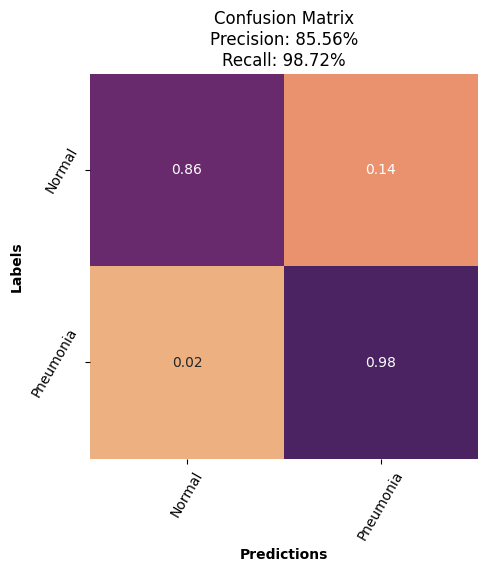

In [13]:
create_confusion_matrix(MODEL_FILEPATH, test_ds)


The image above shows that the model performs better when working with Pneumonia images than Normal images. This is expected since the dataset contains more images from patients suffering from pneumonia. In this case, this does not pose a problem for the goals of the project, since it is more important to correctly identify all the patients that have pneumonia. For those patients misdiagnosed with pneumonia, here is where the medical expertise is required. 

Having physicians that evaluate the outcome of the model and provide feedback of the predictions is vital. Afterwards, this feedback can be used to retrain the model.

## Make Predictions

At the beginning of the notebook it was stablished that one of the key features of the ViT is the attention vectors. These vectors show the weight of each part of the image. The higher the weight, the more attention the model is giving to that area of the image. 

Let's create then a function to not only make predictions, but to show what parts of the image the model is paying more attention to:

In [40]:
def process_attention(
    attention_vals: tf.Tensor,
    n_heads: int,
    h_featmap: int,
    w_featmap: int,
    h_original: int,
    w_original: int,
):
    """
    Process the attention weights for visualization.

    Args:
        attention_vals: The attention weights.
        n_heads: The number of attention heads.
        h_featmap: The height of the feature map.
        w_featmap: The width of the feature map.
        h_original: The height of the original image.
        w_original: The width of the original image.

    Returns:
        The processed attention weights.
    """
    # We only keep the output patch attention
    attention = tf.expand_dims(attention_vals, axis=0)
    attention = tf.reshape(attention[0, :, 0, 1:], (n_heads, w_featmap, h_featmap, 1))
    # Aggregation of the n heads in the last layer
    attention = tf.reduce_mean(attention, axis=0)
    attention = tf.image.resize(
        attention, size=[h_original, w_original], method="lanczos5"
    )
    # Normalize the attention values to have values from zero to one
    attention -= tf.reduce_min(attention)
    attention /= tf.reduce_max(attention)
    return attention


def get_attention(
    attentions: tf.Tensor,
    examples: int,
    num_attention_heads: int,
    h_featmap: int,
    w_featmap: int,
    h_original: int,
    w_original: int,
):
    """
    Get the attention weights for a batch of images.

    Args:
        attentions: The attention weights.
        examples: The number of examples.
        num_attention_heads: The number of attention heads.
        h_featmap: The height of the feature map.
        w_featmap: The width of the feature map.
        h_original: The height of the original image.
        w_original: The width of the original image.

    Returns:
        The attention weights.
    """
    attentions = tf.reshape(attentions, (examples, num_attention_heads, -1))
    last_dimension = int(tf.math.sqrt(float(attentions.shape[-1])).numpy())
    attentions = tf.reshape(
        attentions, (examples, num_attention_heads, last_dimension, last_dimension)
    )

    attention_list = []
    for attention in attentions:
        processed_attenttion = process_attention(
            attention, num_attention_heads, h_featmap, w_featmap, h_original, w_original
        )
        attention_list.append(processed_attenttion)
    return attention_list


def test_predictions(
    model_path: str,
    dataset: tf.data.Dataset,
    n_cols: int = 4,
    examples: int = 16,
    plot_attention: bool = False,
):
    """
    Test the predictions of the model on a given dataset.

    Args:
        model_path: The path to the model to load.
        dataset: The dataset to test the model on.
        n_cols: The number of columns to use when plotting the images.
        examples: The number of examples to plot.
        plot_attention: Whether to plot the attention weights.

    Returns:
        None.
    """
    # Load the model
    model = models.load_model(model_path)
    # Get the configuration of the vit part of the model 
    model_config = model.get_layer("tf_vi_t_model").get_config()
    w_featmap = IMG_SIZE[0] // model_config["patch_size"]
    h_featmap = IMG_SIZE[1] // model_config["patch_size"]

    # Separate the images and the labels
    images = dataset.map(lambda image, _: image, num_parallel_calls=AUTOTUNE)

    labels = dataset.map(lambda _, label: label, num_parallel_calls=AUTOTUNE).unbatch()
    labels = [label.numpy() for label in labels]

    # Make predictions
    model_output = model.predict(images, verbose=0)

    predictions = model_output[0]
    predictions = [float(prediction) for prediction in predictions]
    predicted_classes = [1 if pred > THRESHOLD else 0 for pred in predictions]

    # Obtain the attention vectors
    if plot_attention:
        attentions = get_attention(
            model_output[1],
            examples,
            model_config["num_attention_heads"],
            h_featmap,
            w_featmap,
            IMG_SIZE[0],
            IMG_SIZE[1],
        )

    # Change the shape of the image from [channel, height, width] to [h, w, c]
    images_list = [image.numpy() for image in images][0]
    images_list = [tf.transpose(image, perm=[1, 2, 0]) for image in images_list]

    # Plot the images and the predictions
    n_rows = (
        (examples // n_cols) if (examples % n_cols) == 0 else (examples // n_cols) + 1
    )
    plt.figure(figsize=(5 * n_cols, 5 * n_rows))
    for idx, image in enumerate(images_list):
        # If the option is selected
        if plot_attention:
            # Convert the original image to a grayscale image to plot the attention
            grayscale_image = tf.image.rgb_to_grayscale(image)
            grayscale_image = tf.cast(grayscale_image, dtype=tf.float32) / 255.0
            image = grayscale_image * attentions[0]
        prediction_symbol = "✔️" if labels[idx] == predicted_classes[idx] else "✕"
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(image, cmap="viridis")
        plt.title(
            f"Diagnosis: {IMG_CLASSES[labels[idx]]}\nPrediction: {IMG_CLASSES[predicted_classes[idx]]} {prediction_symbol}\nPrediction probability: {predictions[idx]:.2f}%"
        )
        plt.axis("off")


In [15]:
n_images = 12
prediction_dataset = test_ds.unbatch().shuffle(1000).take(n_images).batch(n_images)


First, let's see normal predictions without attention:

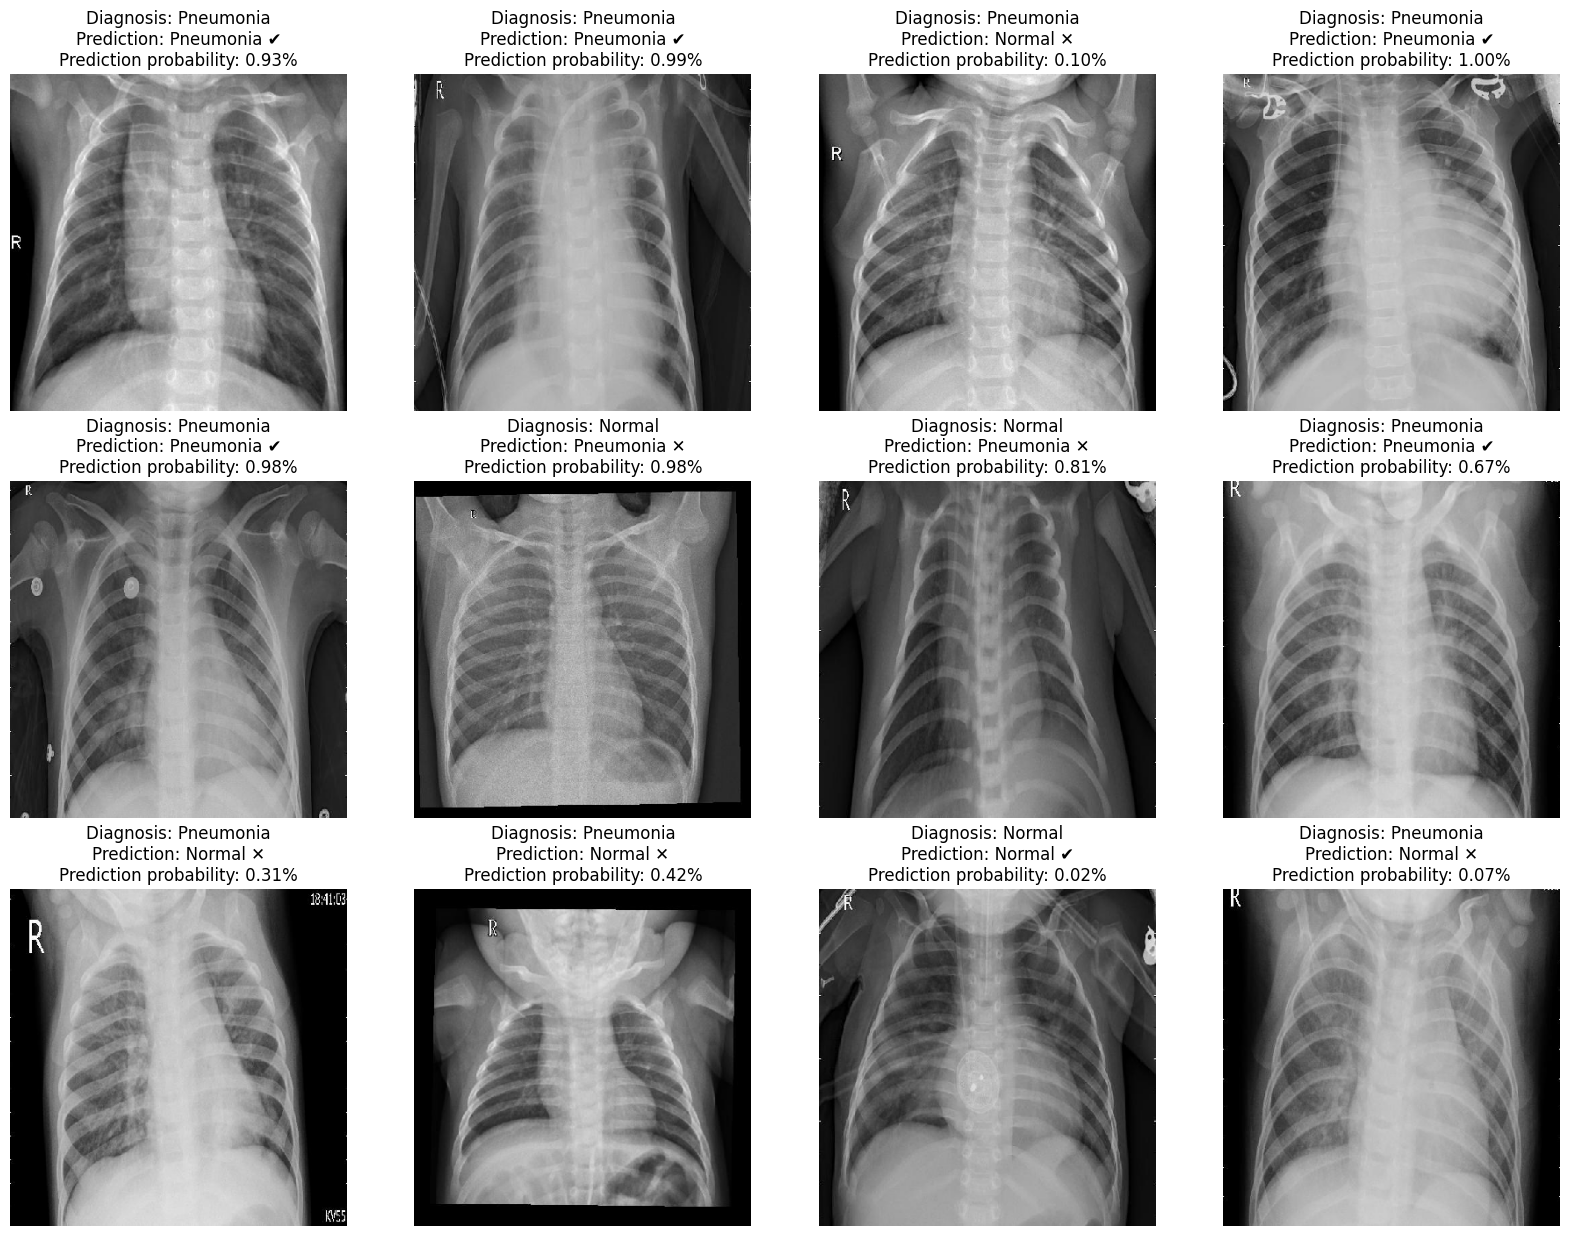

In [35]:
test_predictions(MODEL_FILEPATH, prediction_dataset, examples=n_images)


Please keep in mind that the size of the plotted images is `[384,384]` and not the original size nor the original ratio of the images.

Now, let's see what parts of the image the model is paying more attention to:

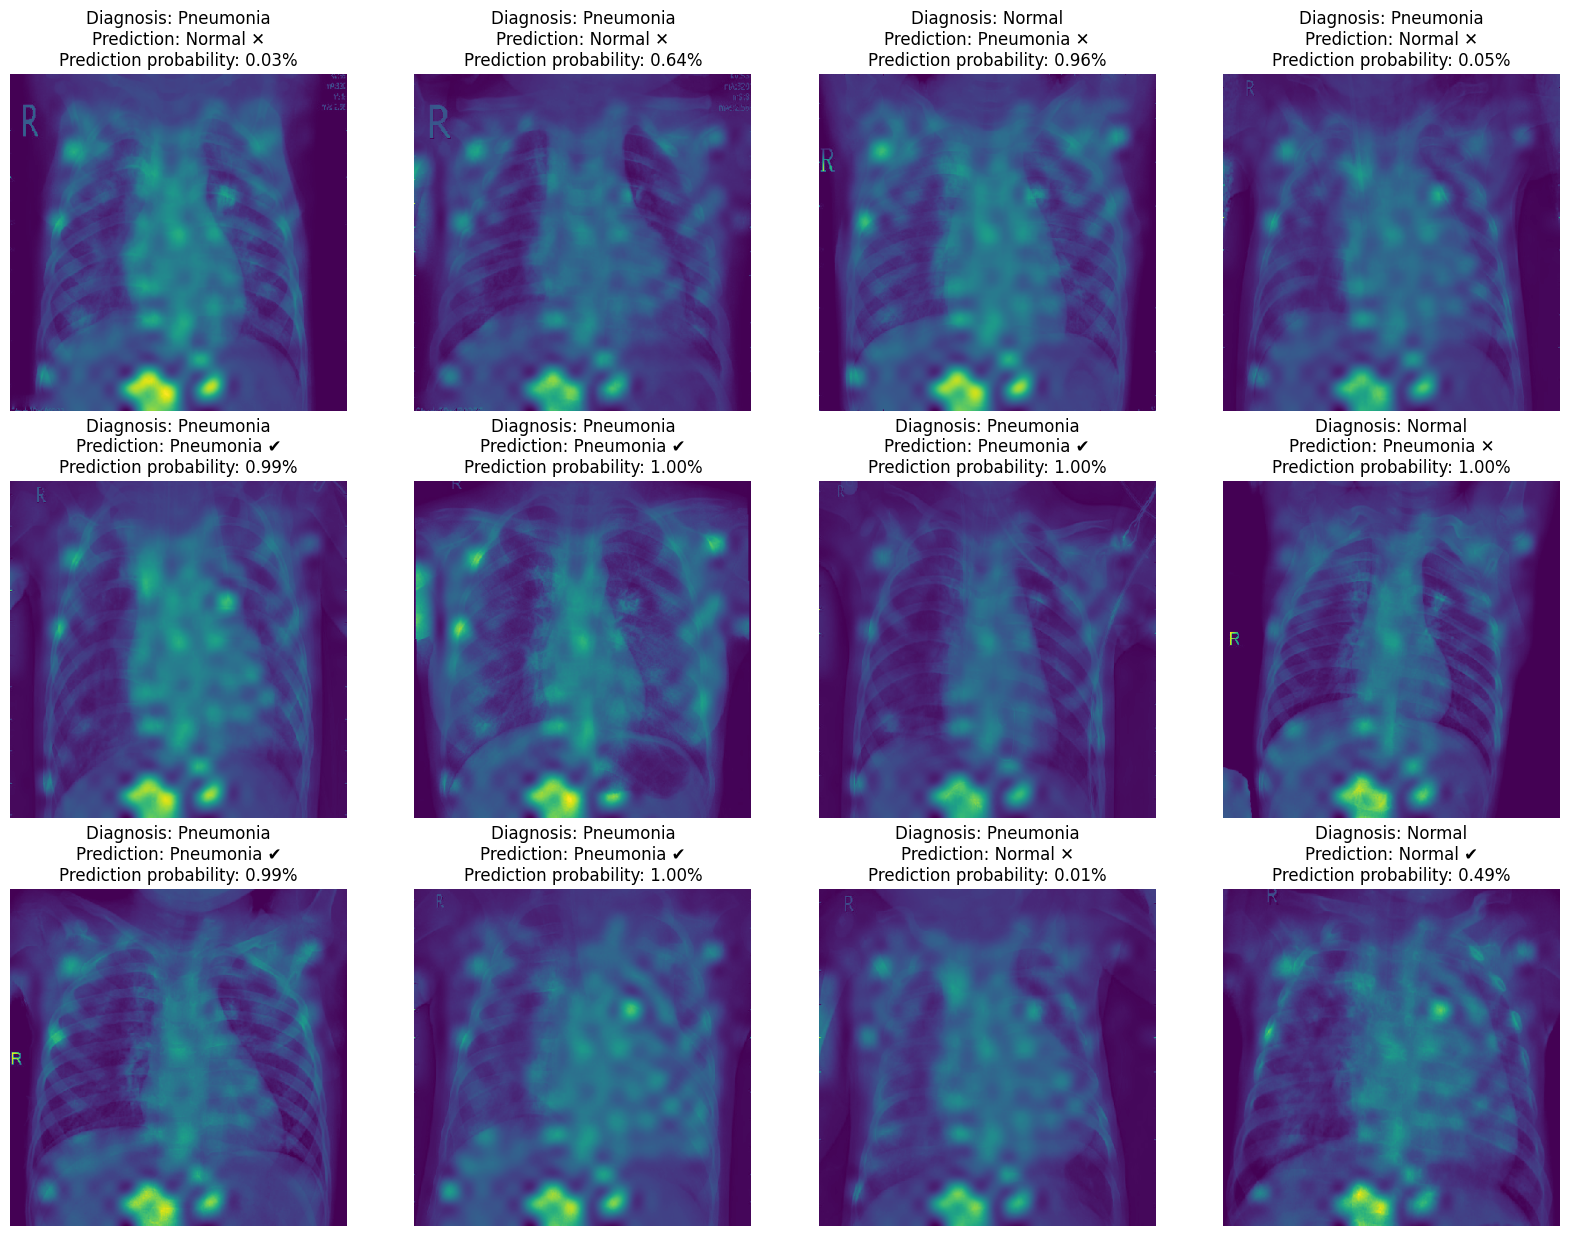

In [36]:
test_predictions(
    MODEL_FILEPATH, prediction_dataset, examples=n_images, plot_attention=True
)


There is a clear pattern to pay more attention at the diaphragm or abdomen of the patients. This may be related to the intensity of the pixels in that zone. But after ignoring that area, it is clear that the model is looking for details in the torax of the patients. Maybe this attention is still related to the intensity of the pixels instead of the medical features of the images.

Please be aware that the ViT model has 12 attention heads in the last layer, i.e., 12 vectors with each representing different areas of attention. The images above are an aggregation of those 12 vectors (mean in this case) to simplify the visuals.

The opinion of a physician will be really appreciated to determine the performance of the model when identifying areas of interest for the diagnosis.

## Single Prediction

The last part of the notebook is dedicated to make a single prediction, but adding the attention map alongside the original image:

In [37]:
def make_single_prediction(model_path: str, image: Image, n_images: int = 1):
    """
    Make a single prediction using the given model and image.

    Args:
        model_path: The path to the model to load.
        image: The image to predict.
        n_images: The number of images to predict.

    Returns:
        The predictions and attention vectors.
    """
    # Load the model
    model = models.load_model(model_path)
    model_config = model.get_layer("tf_vi_t_model").get_config()
    w_featmap = IMG_SIZE[0] // model_config["patch_size"]
    h_featmap = IMG_SIZE[1] // model_config["patch_size"]

    # Convert images to tensorflow Dataset
    permutation = lambda image: tf.transpose(image, perm=[2, 0, 1])
    image_tf = permutation(image_preprocessor(image))
    image_shape = tf.constant(image).shape
    image_ds = tf.data.Dataset.from_tensors(image_tf).batch(1)

    # Make predictions
    model_output = model.predict(image_ds, verbose=0)

    predictions = model_output[0]
    predictions = [float(prediction) for prediction in predictions]
    predicted_classes = [1 if pred > THRESHOLD else 0 for pred in predictions]

    # Obtain the attention vector
    attentions = get_attention(
        model_output[1],
        n_images,
        model_config["num_attention_heads"],
        h_featmap,
        w_featmap,
        image_shape[0],
        image_shape[1],
    )

    # Preparing the images to plot
    grayscale_image = tf.image.rgb_to_grayscale(image)
    grayscale_image = tf.cast(grayscale_image, dtype=tf.float32) / 255.0
    attention_image = grayscale_image * attentions[0]

    # Plot the images and the predictions
    n_cols = 2
    n_rows = n_images
    plt.figure(figsize=(10 * n_cols, 10 * n_rows))
    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(image)
    plt.title(
        f"Diagnosis: {IMG_CLASSES[predicted_classes[0]]}\nPrediction probability: {predictions[0]:.2f}%"
    )
    plt.subplot(n_rows, n_cols, 2)
    plt.imshow(attention_image)
    plt.title(f"Attention zones")
    plt.axis("off")


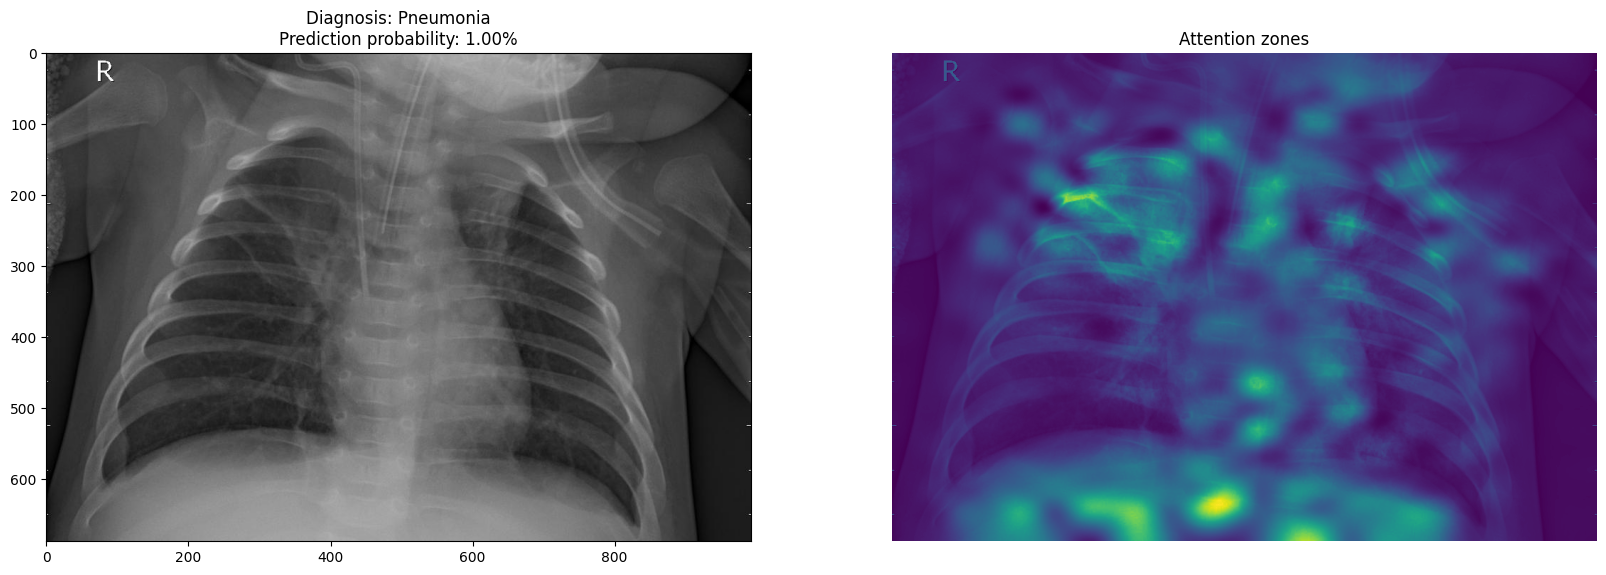

In [38]:
image_path = "../data/raw/pneumonia_xray/test/pneumonia/VIRUS-2352342-0002.jpeg"
image = Image.open(image_path).convert("RGB")
make_single_prediction(MODEL_FILEPATH, image)


This last visual would be the one intended to be given to a physician as assistance tool to validate the diagnosis and the attention areas where the model is focusing.

## Conclusions

Using ViTModel to classify chest x-ray medical images has provided a good performance, being able to correctly classify the majority of the images belonging to patients with Pneumonia. However, the model suffers to correctly classify patients without pneumonia. Access to a bigger dataset may improve the performance of the model when generalizing to new images. 

Even though the performance of the model is really good, the idea behind this project is not to substitute the opinion and criteria of a physician, but to provide tools that increase their productivity and have more insights to diagnose a patient.